In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression #Linear regression proc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.feature_selection import RFE #Recursive Feature Elimination -Selects variables based on performance in model.



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.
from subprocess import check_output
print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

# Import packages to use for data exploration (graphs/plots)
import seaborn as sb
import scipy as sp
# Get function to calculate SpearmanR coefficient.
from scipy.stats import spearmanr

# Makes your plots appear in your notebook instead of creating a file somewhere
%matplotlib inline



#Import module to create our training and test sets.
from sklearn.model_selection import train_test_split

BBTeamSeasonStats.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
ResultDiff.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TeamSpellings.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



In [2]:
# Read csv files into dataframes you can use in you notebook.
data_dir = 'input/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')
df_BBSeason = pd.read_csv(data_dir + 'BBTeamSeasonStats.csv')

In [3]:
#Look at SQL file Ben created
df_BBSeason.head()

,Season,Team,WinLossPct,AvgPts,PtDiff,AvgRebounds,AvgAssists,AvgTurnovers,AvgFouls,FGPct,FTPct,ThPct,AvgStealsPlusBlocks,AvgPtsAgainst,OppFGPct,OppThPct
0,2003,1291,0.41,63,-166,35,11,15,21,0.39,0.70,0.32,11,69,0.45,0.40
1,2007,1144,0.41,76,-95,38,15,17,19,0.44,0.72,0.33,12,79,0.47,0.34
2,2008,1208,0.50,67,29,39,11,14,18,0.43,0.67,0.33,10,66,0.43,0.31
3,2013,1386,0.58,67,107,35,14,11,13,0.44,0.70,0.34,10,63,0.41,0.31
4,2014,1450,0.30,61,-177,35,10,11,18,0.40,0.66,0.33,8,67,0.46,0.37


In [4]:
#Drop unneeded columns from tournament data file 
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

In [5]:
#Prep for getting team seeds
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [6]:
#Renaming columns to make joining easier
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [7]:
#Join winning and losing seeds data together.  Similar to SQL join.
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [8]:
df_concat.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [9]:
##Make a df to play with so I don't mess up df_concat
##We need to combine other stats and differentials into a dataframe the same way as Seed_diff is there.
df_concat2 = df_concat

In [10]:
df_concat2.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [11]:
#Separate winning and losing team data so they're not on the same row.
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [12]:
df_winseeds.head()

,Season,Wteam,win_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [13]:
#Rename column for easier joining of df_WinStats and other winning data.
df_WinStats = df_BBSeason.rename(columns={'Team':'Wteam'})

In [14]:
df_WinStats.head()

,Season,Wteam,WinLossPct,AvgPts,PtDiff,AvgRebounds,AvgAssists,AvgTurnovers,AvgFouls,FGPct,FTPct,ThPct,AvgStealsPlusBlocks,AvgPtsAgainst,OppFGPct,OppThPct
0,2003,1291,0.41,63,-166,35,11,15,21,0.39,0.70,0.32,11,69,0.45,0.40
1,2007,1144,0.41,76,-95,38,15,17,19,0.44,0.72,0.33,12,79,0.47,0.34
2,2008,1208,0.50,67,29,39,11,14,18,0.43,0.67,0.33,10,66,0.43,0.31
3,2013,1386,0.58,67,107,35,14,11,13,0.44,0.70,0.34,10,63,0.41,0.31
4,2014,1450,0.30,61,-177,35,10,11,18,0.40,0.66,0.33,8,67,0.46,0.37


In [15]:
# Join Winstats and other winning team data.
df_WinStats2 = pd.merge(left=df_winseeds, right=df_WinStats, on=['Season', 'Wteam'])

In [16]:
#Same process for loss stats
df_LossStats = df_BBSeason.rename(columns={'Team':'Lteam'})

In [17]:
#Same process for loss stats
df_LossStats2 = pd.merge(left=df_lossseeds, right=df_LossStats, on=['Season', 'Lteam'])

In [18]:
df_LossStats.head()

,Season,Lteam,WinLossPct,AvgPts,PtDiff,AvgRebounds,AvgAssists,AvgTurnovers,AvgFouls,FGPct,FTPct,ThPct,AvgStealsPlusBlocks,AvgPtsAgainst,OppFGPct,OppThPct
0,2003,1291,0.41,63,-166,35,11,15,21,0.39,0.70,0.32,11,69,0.45,0.40
1,2007,1144,0.41,76,-95,38,15,17,19,0.44,0.72,0.33,12,79,0.47,0.34
2,2008,1208,0.50,67,29,39,11,14,18,0.43,0.67,0.33,10,66,0.43,0.31
3,2013,1386,0.58,67,107,35,14,11,13,0.44,0.70,0.34,10,63,0.41,0.31
4,2014,1450,0.30,61,-177,35,10,11,18,0.40,0.66,0.33,8,67,0.46,0.37


In [19]:
#Need this?
# df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])

In [20]:
# Use .add_prefix to add a prefix to each of the columns in your data frame
# Makes it easier to identify which columns are the win/loss stats so we can create our diferentials.

# Add W_ to each of the columns in the WinStats2 data frame
df_WinStatsPrefixed = df_WinStats2.add_prefix("W_")

# Add L_ to each of the columns in the LossStats2 data frame
df_LossStatsPrefixed = df_LossStats2.add_prefix("L_")

df_WinStatsPrefixed.head()

,W_Season,W_Wteam,W_win_seed,W_WinLossPct,W_AvgPts,W_PtDiff,W_AvgRebounds,W_AvgAssists,W_AvgTurnovers,W_AvgFouls,W_FGPct,W_FTPct,W_ThPct,W_AvgStealsPlusBlocks,W_AvgPtsAgainst,W_OppFGPct,W_OppThPct
0,2003,1328,1,0.80,71,330,37,14,11,18,0.45,0.71,0.39,10,60,0.40,0.33
1,2003,1448,2,0.83,78,313,42,14,15,18,0.46,0.75,0.34,10,67,0.40,0.34
2,2003,1393,3,0.83,80,296,41,14,13,16,0.47,0.69,0.33,15,69,0.39,0.31
3,2003,1257,4,0.80,81,401,38,16,13,22,0.46,0.70,0.36,11,68,0.40,0.30
4,2003,1280,5,0.70,70,300,37,14,15,15,0.47,0.68,0.34,12,60,0.40,0.33


In [21]:
# Rename columns in order to join win/loss stats rows.
df_WinStatsPrefixed = df_WinStatsPrefixed.rename(columns={'W_Season':'Season', 'W_Wteam':'Wteam'})
df_LossStatsPrefixed = df_LossStatsPrefixed.rename(columns={'L_Season':'Season', 'L_Lteam':'Lteam'})

In [22]:
df_LossStatsPrefixed.head()

,Season,Lteam,L_loss_seed,L_WinLossPct,L_AvgPts,L_PtDiff,L_AvgRebounds,L_AvgAssists,L_AvgTurnovers,L_AvgFouls,L_FGPct,L_FTPct,L_ThPct,L_AvgStealsPlusBlocks,L_AvgPtsAgainst,L_OppFGPct,L_OppThPct
0,2003,1328,1,0.80,71,330,37,14,11,18,0.45,0.71,0.39,10,60,0.40,0.33
1,2003,1448,2,0.83,78,313,42,14,15,18,0.46,0.75,0.34,10,67,0.40,0.34
2,2003,1393,3,0.83,80,296,41,14,13,16,0.47,0.69,0.33,15,69,0.39,0.31
3,2003,1257,4,0.80,81,401,38,16,13,22,0.46,0.70,0.36,11,68,0.40,0.30
4,2003,1280,5,0.70,70,300,37,14,15,15,0.47,0.68,0.34,12,60,0.40,0.33


In [23]:
# Join win/loss stat rows for easy calculation of differentials.
df_concat2 = pd.merge(left=df_concat2, right=df_LossStatsPrefixed,  on=['Season', 'Lteam'])
df_concat3 = pd.merge(left=df_concat2, right=df_WinStatsPrefixed,  on=['Season', 'Wteam'])

In [24]:
##Use this dataframe to calculate stats for wins and losses in separate dataframes by just reversing the calculations.
##For example, for the winning team, calculate avg_point_diff as (W_AvgPts_x - L_AvgPts_x), 
##but in another dataframe for the losers calculate it as (L_AvgPts_x - W_AvgPts_x).
##Once all calculations are made in separate dataframes add the 'Result' column to each (like in this original notebook)
##and finally UNION all records.  This way, we have examples of both wins and losses with appropriate stats.
##Once this is all complete, drop all columns exept for Season, Wteam, LTeam, seed_diff, Result, and all calculated diffs.
##THAT should be our final data set.

df_concat3.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,L_loss_seed,L_WinLossPct,L_AvgPts,L_PtDiff,...,W_AvgAssists,W_AvgTurnovers,W_AvgFouls,W_FGPct,W_FTPct,W_ThPct,W_AvgStealsPlusBlocks,W_AvgPtsAgainst,W_OppFGPct,W_OppThPct
0,2003,1421,1411,16,16,0,16,0.60,72,59,...,13,16,19,0.43,0.76,0.36,10,78,0.46,0.37
1,2003,1112,1436,1,16,-15,16,0.66,67,135,...,17,14,17,0.46,0.70,0.35,12,70,0.41,0.32
2,2003,1112,1211,1,9,-8,9,0.74,77,275,...,17,14,17,0.46,0.70,0.35,12,70,0.41,0.32
3,2003,1112,1323,1,5,-4,5,0.71,80,276,...,17,14,17,0.46,0.70,0.35,12,70,0.41,0.32
4,2003,1113,1272,10,7,3,7,0.79,74,252,...,15,14,19,0.48,0.67,0.32,9,69,0.45,0.34


In [25]:
# Winner Stats
# if you set a dataframe = to another dataframe it will modify the the original data frame.  
# Use copy to preserve and not accidentally do bad things and upset yourself later
df_WinnerStats = df_concat3.copy(deep=True)

# Calculate Differentials
#Also add a column called Result and set it to =1 for all winning rows.  This is our target variable for predication.  
df_WinnerStats['diff_WinLossPct'] = df_WinnerStats.W_WinLossPct - df_WinnerStats.L_WinLossPct
df_WinnerStats['diff_AvgPts'] = df_WinnerStats.W_AvgPts - df_WinnerStats.L_AvgPts
df_WinnerStats['diff_PtDiff'] = df_WinnerStats.W_PtDiff - df_WinnerStats.L_PtDiff
df_WinnerStats['diff_AvgRebounds'] = df_WinnerStats.W_AvgRebounds - df_WinnerStats.L_AvgRebounds
df_WinnerStats['diff_AvgAssists'] = df_WinnerStats.W_AvgAssists - df_WinnerStats.L_AvgAssists
df_WinnerStats['diff_AvgTurnovers'] = df_WinnerStats.W_AvgTurnovers - df_WinnerStats.L_AvgTurnovers
df_WinnerStats['diff_AvgFouls'] = df_WinnerStats.W_AvgFouls - df_WinnerStats.L_AvgFouls
df_WinnerStats['diff_FGPct'] = df_WinnerStats.W_FGPct - df_WinnerStats.L_FGPct
df_WinnerStats['diff_FTPct'] = df_WinnerStats.W_FTPct - df_WinnerStats.L_FTPct
df_WinnerStats['diff_ThPct'] = df_WinnerStats.W_ThPct - df_WinnerStats.L_ThPct
df_WinnerStats['diff_AvgStealsPlusBlocks'] = df_WinnerStats.W_AvgStealsPlusBlocks - df_WinnerStats.L_AvgStealsPlusBlocks
df_WinnerStats['diff_AvgPtsAgainst'] = df_WinnerStats.W_AvgPtsAgainst - df_WinnerStats.L_AvgPtsAgainst
df_WinnerStats['diff_OppFGPct'] = df_WinnerStats.W_OppFGPct - df_WinnerStats.L_OppFGPct
df_WinnerStats['diff_OppThPct'] = df_WinnerStats.W_OppThPct - df_WinnerStats.L_OppThPct
df_WinnerStats['Result'] = 1




In [26]:
df_WinnerStats

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,L_loss_seed,L_WinLossPct,L_AvgPts,L_PtDiff,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
0,2003,1421,1411,16,16,0,16,0.60,72,59,...,1,1,-0.02,0.14,0.04,2,8,0.04,0.04,1
1,2003,1112,1436,1,16,-15,16,0.66,67,135,...,0,2,0.02,0.04,0.01,3,7,0.00,-0.01,1
2,2003,1112,1211,1,9,-8,9,0.74,77,275,...,0,-1,-0.01,-0.02,-0.03,2,2,-0.01,-0.05,1
3,2003,1112,1323,1,5,-4,5,0.71,80,276,...,2,1,0.01,-0.06,-0.03,-1,-1,0.00,-0.05,1
4,2003,1113,1272,10,7,3,7,0.79,74,252,...,1,1,0.04,0.02,-0.03,-3,4,0.05,0.02,1
5,2003,1141,1166,11,6,5,6,0.88,79,492,...,5,3,0.01,0.08,-0.01,-1,9,0.02,0.02,1
6,2003,1143,1301,8,9,-1,9,0.60,72,132,...,0,-1,0.01,-0.08,0.03,-1,1,-0.01,-0.01,1
7,2003,1163,1140,5,12,-7,12,0.74,72,272,...,2,-3,0.00,-0.08,0.01,4,8,-0.03,0.01,1
8,2003,1163,1390,5,4,1,4,0.74,72,164,...,1,0,0.03,-0.01,0.03,5,5,-0.03,0.02,1
9,2003,1181,1161,3,14,-11,14,0.57,74,40,...,-2,1,-0.06,0.01,0.00,4,-2,-0.01,0.00,1


In [27]:
df_WinnerStats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [28]:
# Loser Stats
df_LoserStats = df_concat3.copy(deep=True)

# Calculate Differentials
#Also add a column called Result and set it to =0 for all losing rows.  This is our target variable for predication.  
df_LoserStats['diff_WinLossPct'] = df_WinnerStats.L_WinLossPct - df_WinnerStats.W_WinLossPct
df_LoserStats['diff_AvgPts'] = df_WinnerStats.L_AvgPts - df_WinnerStats.W_AvgPts
df_LoserStats['diff_PtDiff'] = df_WinnerStats.L_PtDiff - df_WinnerStats.W_PtDiff
df_LoserStats['diff_AvgRebounds'] = df_WinnerStats.L_AvgRebounds - df_WinnerStats.W_AvgRebounds
df_LoserStats['diff_AvgAssists'] = df_WinnerStats.L_AvgAssists - df_WinnerStats.W_AvgAssists
df_LoserStats['diff_AvgTurnovers'] = df_WinnerStats.L_AvgTurnovers - df_WinnerStats.W_AvgTurnovers
df_LoserStats['diff_AvgFouls'] = df_WinnerStats.L_AvgFouls - df_WinnerStats.W_AvgFouls
df_LoserStats['diff_FGPct'] = df_WinnerStats.L_FGPct - df_WinnerStats.W_FGPct
df_LoserStats['diff_FTPct'] = df_WinnerStats.L_FTPct - df_WinnerStats.W_FTPct
df_LoserStats['diff_ThPct'] = df_WinnerStats.L_ThPct - df_WinnerStats.W_ThPct
df_LoserStats['diff_AvgStealsPlusBlocks'] = df_WinnerStats.L_AvgStealsPlusBlocks - df_WinnerStats.W_AvgStealsPlusBlocks
df_LoserStats['diff_AvgPtsAgainst'] = df_WinnerStats.L_AvgPtsAgainst - df_WinnerStats.W_AvgPtsAgainst
df_LoserStats['diff_OppFGPct'] = df_WinnerStats.L_OppFGPct - df_WinnerStats.W_OppFGPct
df_LoserStats['diff_OppThPct'] = df_WinnerStats.L_OppThPct - df_WinnerStats.W_OppThPct
df_LoserStats['Result'] = 0

In [29]:
df_LoserStats

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,L_loss_seed,L_WinLossPct,L_AvgPts,L_PtDiff,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
0,2003,1421,1411,16,16,0,16,0.60,72,59,...,-1,-1,0.02,-0.14,-0.04,-2,-8,-0.04,-0.04,0
1,2003,1112,1436,1,16,-15,16,0.66,67,135,...,0,-2,-0.02,-0.04,-0.01,-3,-7,0.00,0.01,0
2,2003,1112,1211,1,9,-8,9,0.74,77,275,...,0,1,0.01,0.02,0.03,-2,-2,0.01,0.05,0
3,2003,1112,1323,1,5,-4,5,0.71,80,276,...,-2,-1,-0.01,0.06,0.03,1,1,0.00,0.05,0
4,2003,1113,1272,10,7,3,7,0.79,74,252,...,-1,-1,-0.04,-0.02,0.03,3,-4,-0.05,-0.02,0
5,2003,1141,1166,11,6,5,6,0.88,79,492,...,-5,-3,-0.01,-0.08,0.01,1,-9,-0.02,-0.02,0
6,2003,1143,1301,8,9,-1,9,0.60,72,132,...,0,1,-0.01,0.08,-0.03,1,-1,0.01,0.01,0
7,2003,1163,1140,5,12,-7,12,0.74,72,272,...,-2,3,0.00,0.08,-0.01,-4,-8,0.03,-0.01,0
8,2003,1163,1390,5,4,1,4,0.74,72,164,...,-1,0,-0.03,0.01,-0.03,-5,-5,0.03,-0.02,0
9,2003,1181,1161,3,14,-11,14,0.57,74,40,...,2,-1,0.06,-0.01,0.00,-4,2,0.01,0.00,0


In [30]:
df_LoserStats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [31]:
# Append win/loss stats so we have all our differentials, other stats, and target variable for all wins and losses on separate 
#rows in the same data set.
# Append is the same as Union in SQL

concats = [df_WinnerStats, df_LoserStats]
df_Concats = df_WinnerStats.append(df_LoserStats)
df_Concats

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,L_loss_seed,L_WinLossPct,L_AvgPts,L_PtDiff,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
0,2003,1421,1411,16,16,0,16,0.60,72,59,...,1,1,-0.02,0.14,0.04,2,8,0.04,0.04,1
1,2003,1112,1436,1,16,-15,16,0.66,67,135,...,0,2,0.02,0.04,0.01,3,7,0.00,-0.01,1
2,2003,1112,1211,1,9,-8,9,0.74,77,275,...,0,-1,-0.01,-0.02,-0.03,2,2,-0.01,-0.05,1
3,2003,1112,1323,1,5,-4,5,0.71,80,276,...,2,1,0.01,-0.06,-0.03,-1,-1,0.00,-0.05,1
4,2003,1113,1272,10,7,3,7,0.79,74,252,...,1,1,0.04,0.02,-0.03,-3,4,0.05,0.02,1
5,2003,1141,1166,11,6,5,6,0.88,79,492,...,5,3,0.01,0.08,-0.01,-1,9,0.02,0.02,1
6,2003,1143,1301,8,9,-1,9,0.60,72,132,...,0,-1,0.01,-0.08,0.03,-1,1,-0.01,-0.01,1
7,2003,1163,1140,5,12,-7,12,0.74,72,272,...,2,-3,0.00,-0.08,0.01,4,8,-0.03,0.01,1
8,2003,1163,1390,5,4,1,4,0.74,72,164,...,1,0,0.03,-0.01,0.03,5,5,-0.03,0.02,1
9,2003,1181,1161,3,14,-11,14,0.57,74,40,...,-2,1,-0.06,0.01,0.00,4,-2,-0.01,0.00,1


In [32]:
#We have differentials, but now also have a ton of extra columns
df_Concats.columns

Index(['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff',
       'L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct', 'diff_WinLossPct',
       'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists',
       'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct',
       'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst',
       'diff_OppFGPct', 'diff_OppThPct', 'Result'],
      dtype='object')

In [33]:
#Drop unneeded/unwanted columns.
df_Concats.drop(labels=['L_loss_seed', 'L_WinLossPct', 'L_AvgPts', 'L_PtDiff', 'L_AvgRebounds',
       'L_AvgAssists', 'L_AvgTurnovers', 'L_AvgFouls', 'L_FGPct', 'L_FTPct',
       'L_ThPct', 'L_AvgStealsPlusBlocks', 'L_AvgPtsAgainst', 'L_OppFGPct',
       'L_OppThPct', 'W_win_seed', 'W_WinLossPct', 'W_AvgPts', 'W_PtDiff',
       'W_AvgRebounds', 'W_AvgAssists', 'W_AvgTurnovers', 'W_AvgFouls',
       'W_FGPct', 'W_FTPct', 'W_ThPct', 'W_AvgStealsPlusBlocks',
       'W_AvgPtsAgainst', 'W_OppFGPct', 'W_OppThPct'],inplace=True, axis=1)



In [34]:
df_Concats.head()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,diff_WinLossPct,diff_AvgPts,diff_PtDiff,diff_AvgRebounds,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
0,2003,1421,1411,16,16,0,-0.15,-1,-269,-2,...,1,1,-0.02,0.14,0.04,2,8,0.04,0.04,1
1,2003,1112,1436,1,16,-15,0.23,18,284,4,...,0,2,0.02,0.04,0.01,3,7,0.00,-0.01,1
2,2003,1112,1211,1,9,-8,0.15,8,144,6,...,0,-1,-0.01,-0.02,-0.03,2,2,-0.01,-0.05,1
3,2003,1112,1323,1,5,-4,0.18,5,143,4,...,2,1,0.01,-0.06,-0.03,-1,-1,0.00,-0.05,1
4,2003,1113,1272,10,7,3,-0.17,1,-55,-2,...,1,1,0.04,0.02,-0.03,-3,4,0.05,0.02,1


In [35]:
# Check it out.  How did we do?
df_Concats.describe()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,diff_WinLossPct,diff_AvgPts,diff_PtDiff,diff_AvgRebounds,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.00000,1828.000000,1828.00000,...,1828.000000,1828.000000,1.828000e+03,1.828000e+03,1.828000e+03,1828.000000,1828.000000,1.828000e+03,1.828000e+03,1828.000000
mean,2009.578775,1294.508753,1294.598468,5.112691,8.805252,-3.692560,2.556914e-17,0.00000,0.000000,0.00000,...,0.000000,0.000000,6.194899e-18,-1.396889e-18,-1.852396e-18,0.000000,0.000000,2.125701e-19,1.245053e-18,0.500000
std,4.037974,102.358912,106.976007,3.982913,4.630086,6.507678,1.421625e-01,7.25054,205.540046,3.73375,...,2.147541,2.565187,3.211399e-02,5.158463e-02,3.787312e-02,2.981975,6.378501,3.126594e-02,3.153438e-02,0.500137
min,2003.000000,1104.000000,1102.000000,1.000000,1.000000,-15.000000,-6.300000e-01,-23.00000,-740.000000,-18.00000,...,-8.000000,-7.000000,-1.100000e-01,-1.700000e-01,-1.400000e-01,-9.000000,-25.000000,-1.200000e-01,-1.000000e-01,0.000000
25%,2006.000000,1211.000000,1208.000000,2.000000,5.000000,-8.000000,-9.000000e-02,-5.00000,-127.000000,-2.00000,...,-1.000000,-2.000000,-2.000000e-02,-4.000000e-02,-2.000000e-02,-2.000000,-4.000000,-2.000000e-02,-2.000000e-02,0.000000
50%,2010.000000,1277.000000,1295.000000,4.000000,9.000000,-3.500000,0.000000e+00,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.500000
75%,2013.000000,1393.000000,1393.000000,8.000000,13.000000,1.000000,9.000000e-02,5.00000,127.000000,2.00000,...,1.000000,2.000000,2.000000e-02,4.000000e-02,2.000000e-02,2.000000,4.000000,2.000000e-02,2.000000e-02,1.000000
max,2016.000000,1463.000000,1463.000000,16.000000,16.000000,13.000000,6.300000e-01,23.00000,740.000000,18.00000,...,8.000000,7.000000,1.100000e-01,1.700000e-01,1.400000e-01,9.000000,25.000000,1.200000e-01,1.000000e-01,1.000000


In [36]:
#Save a csv file with this data to the same directory with my other data.
#Also renamed file to make it a little more descriptive as to what's in it.
df_Concats.to_csv(data_dir + 'ResultDiff.csv')

In [37]:
#Check the directory to make sure my csv is there.
print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

BBTeamSeasonStats.csv
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
ResultDiff.csv
SampleSubmission.csv
Seasons.csv
Teams.csv
TeamSpellings.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv



# Here is where we start exploring the data we have so far.

In [38]:
# Create training and test sets for the data.
# df_train is the test set.  Use this one for analysis.
# df_test is the test set.  Don't do anything to this one for now.
df_train, df_test = train_test_split(df_Concats, test_size=0.33)

In [39]:
# Take a look.
df_train.describe()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,diff_WinLossPct,diff_AvgPts,diff_PtDiff,diff_AvgRebounds,...,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct,Result
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,...,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,2009.569444,1294.212418,1295.821078,5.176471,8.691993,-3.515523,0.002386,0.152778,3.370098,0.134804,...,-0.006536,0.036765,-0.000400,0.000376,-0.000605,0.030229,0.047386,-0.000196,-0.000221,0.506536
std,4.064293,101.541362,106.833254,4.008972,4.601440,6.525609,0.142558,7.181699,205.913765,3.615941,...,2.133705,2.559408,0.032315,0.051545,0.037922,3.002572,6.293272,0.031336,0.031781,0.500162
min,2003.000000,1104.000000,1103.000000,1.000000,1.000000,-15.000000,-0.520000,-21.000000,-740.000000,-11.000000,...,-7.000000,-7.000000,-0.110000,-0.170000,-0.140000,-9.000000,-19.000000,-0.090000,-0.090000,0.000000
25%,2006.000000,1211.000000,1210.000000,2.000000,5.000000,-8.000000,-0.090000,-5.000000,-129.000000,-2.000000,...,-1.000000,-2.000000,-0.020000,-0.040000,-0.020000,-2.000000,-4.000000,-0.020000,-0.020000,0.000000
50%,2010.000000,1277.000000,1300.000000,4.000000,9.000000,-3.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2013.000000,1393.000000,1396.000000,8.000000,13.000000,1.000000,0.092500,5.000000,132.250000,2.000000,...,1.000000,2.000000,0.020000,0.040000,0.020000,2.000000,4.000000,0.020000,0.020000,1.000000
max,2016.000000,1463.000000,1462.000000,16.000000,16.000000,13.000000,0.630000,21.000000,740.000000,14.000000,...,8.000000,7.000000,0.110000,0.170000,0.140000,9.000000,18.000000,0.120000,0.100000,1.000000


In [40]:
# Crosstab table of seed_diff vs result
result_seed_diff = pd.crosstab(index=df_train["Result"], 
                           columns=df_train["seed_diff"],
                              margins=True)

result_seed_diff.index= ["loss","win", 'nan']

result_seed_diff

seed_diff,-15,-13,-12,-11,-10,-9,-8,-7,-6,-5,...,4,5,6,7,8,9,10,11,13,All
loss,33,30,2,41,1,32,49,40,4,42,...,9,27,2,22,16,9,2,5,4,604
win,38,36,2,34,0,31,54,44,3,39,...,7,23,3,21,18,6,1,4,3,620
nan,71,66,4,75,1,63,103,84,7,81,...,16,50,5,43,34,15,3,9,7,1224


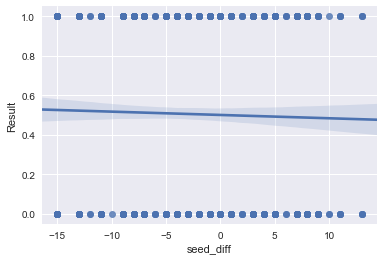

In [41]:
# Scatter plot specifically designed for logistic regression
sb.regplot(x='seed_diff', y='Result', data = df_train, scatter=True, logistic=True)

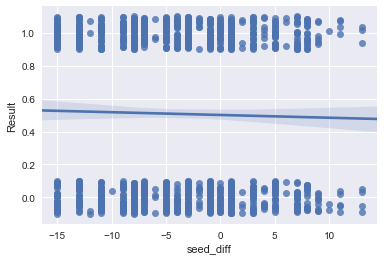

In [42]:
ax = sb.regplot(x='seed_diff', y='Result', data=df_train,
                 logistic=True, n_boot=500, y_jitter=.1
               )

In [43]:
# Separate variables to compare for spearmanr coefficient into separate dataframes.
diff = df_train['seed_diff']
result = df_train['Result']
spearmanr_coefficient, p_value = spearmanr(diff,result, nan_policy='omit')

In [44]:
##Varies between -1 and +1 with 0 implying no correlation. 
##Positive correlations imply that as x increases, so does y. 
##Negative correlations imply that as x increases, y decreases.

print(spearmanr_coefficient)

-0.018121554527


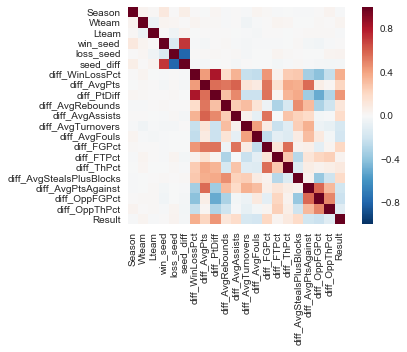

In [45]:
# Correlation heatmap for all variables.
# Remember, 0 = no correlation.  
# +1 = strong positive correlation.  -1 = strong negative correlation, 
sb.heatmap(df_train.corr(), square=True)

In [46]:
#Get a count of each result to see the distribution.
df_train['Result'].value_counts()

1    620
0    604
Name: Result, dtype: int64

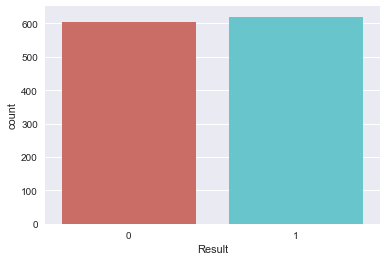

In [47]:
#Same as above, but in a plot.
sb.countplot(x='Result', data=df_train, palette='hls')

In [48]:
#Mean of all variables based on Result.
df_train.groupby('Result').mean()

,Season,Wteam,Lteam,win_seed,loss_seed,seed_diff,diff_WinLossPct,diff_AvgPts,diff_PtDiff,diff_AvgRebounds,diff_AvgAssists,diff_AvgTurnovers,diff_AvgFouls,diff_FGPct,diff_FTPct,diff_ThPct,diff_AvgStealsPlusBlocks,diff_AvgPtsAgainst,diff_OppFGPct,diff_OppThPct
Result,,,,,,,,,,,,,,,,,,,,
0,2009.615894,1291.793046,1297.043046,5.173841,8.544702,-3.370861,-0.050232,-1.394040,-88.814570,-0.298013,-0.509934,0.362583,0.506623,-0.007268,-0.001308,-0.004321,-0.548013,1.273179,0.006623,0.003791
1,2009.524194,1296.569355,1294.630645,5.179032,8.835484,-3.656452,0.053645,1.659677,93.175806,0.556452,0.459677,-0.366129,-0.420968,0.006290,0.002016,0.003016,0.593548,-1.146774,-0.006839,-0.004129


# Variable Selection with Recursive Feature Elimination (RFE). 

Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [49]:
#Create an array with all possible variables in it except the target. 
data_variables=df_train.columns.values.tolist()
y=['Result']
X=[i for i in data_variables if i not in y]

print(X)

['Season', 'Wteam', 'Lteam', 'win_seed', 'loss_seed', 'seed_diff', 'diff_WinLossPct', 'diff_AvgPts', 'diff_PtDiff', 'diff_AvgRebounds', 'diff_AvgAssists', 'diff_AvgTurnovers', 'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct', 'diff_ThPct', 'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst', 'diff_OppFGPct', 'diff_OppThPct']


In [50]:
# Without n_features_to_select the proc will default to select half the variables for inclusion.
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select = 10)
rfe = rfe.fit(df_train[X], df_train[y])
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False  True  True False False False  True
  True False  True  True  True  True  True  True]
[11 10  9  6  2  5  1  1  4  8  3  1  1  7  1  1  1  1  1  1]


C:\Users\bburns\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
# Add selected columns to a new array.
# The columns for inclusion are marked by True or 1 in the output above.  
cols=['diff_WinLossPct', 'diff_AvgPts', 'diff_AvgTurnovers', 
      'diff_AvgFouls', 'diff_FGPct', 'diff_FTPct', 'diff_ThPct', 
      'diff_AvgStealsPlusBlocks', 'diff_AvgPtsAgainst', 'diff_OppThPct']
X=df_train[cols]
y=df_train['Result']

# Create Actual Model
## Fit the Model

In [52]:
import statsmodels.api as sm  
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

C:\Users\bburns\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.574955
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.170     
Dependent Variable:    Result             AIC:                1427.4903 
Date:                  2018-02-20 17:53   BIC:                1478.5891 
No. Observations:      1224               Log-Likelihood:     -703.75   
Df Model:              9                  LL-Null:            -848.31   
Df Residuals:          1214               LLR p-value:        5.2778e-57
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
diff_WinLossPct          -0.2042   0.8347 -0.2447 0

## Examine the output above

Psuedo R-squ.:  Psuedo R-squared.  Not generally agreed what a "good" value for this is, but higher is better.

AIC: Akaike's Information Criterion.  Smaller is better.

BIC:  Bayesian Information Criterion.  Smaller is better.  Usually lower than 0.
    NOTE:  AIC and BIC are both 'information criteria.' Basically, they are measures of how much information is lost when we
represent the complex sample data through the model. We want to lose as little information as possible, so we try to
minimize AIC and BIC.

Log-Likelihood, L-Null:  Together, these constitute the Likelihood Ratio Test (LR).  Log-Likelhood is the log-likelihood of our model, LL-Null is the log-likelihood of a model where all of our coefficients are assumed to = 0 (basically, like they don't exist) and only uses the intercept.  Long story short, you want Log-Likelihood to be much closer to 0 than LL-Null.  
    NOTE:  Also use these to get Deviance, where Deviance = log-likelihood * (-2).  Smaller Deviance values indicate a better fitting model, with Deviance = 0 being a perfectly fit model.  Can also be used to calculate AIC and BIC.

coef:  Estimated coefficient, or the log odds.  When exponentiated, this number is the odds ratio and each unit increase is a 100% increase in the odds the event will occur holding everything else constant. 

std error:  Variability in the estimate given sampling distribution, used in statistical tests and confidence intervals.  Larger standard error tends to mean larger confidence interval, hence more variability.

z:  z-score.  Similar to the p-score test of statistical significance. z-scores with absolute value greater than 1.96 mean about the same thing as a p-value less than 0.05.  Equal to coef/std err, and determines if the coefficient is statistically different from 0 (also known as the Wald test).

P> |z|:  p-score. If this is not less than 0.05, then the variable is not statistically significant.

[0.025 0.975] :  Confidence interval.  This is a 97.5% confidence interval, meaning that there is a 97.5% chance that the actual value of the coefficient is within this range. 


In [53]:
# Exponentiate coefficients to convert to odds.
np.exp(result.params)

diff_WinLossPct             0.815291
diff_AvgPts                 1.173177
diff_AvgTurnovers           0.902828
diff_AvgFouls               0.928980
diff_FGPct                  7.768788
diff_FTPct                  5.067074
diff_ThPct                  0.010859
diff_AvgStealsPlusBlocks    1.063535
diff_AvgPtsAgainst          0.848115
diff_OppThPct               0.697162
dtype: float64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
## Accuracy is the proportion of true positives and true negatives vs false positives and false negatives.
# In your confusin matrix, it's top-left + bottom-right / total.
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.67


#### 10-fold cross validation
In k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

In [56]:
#10-Fold Cross-Validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.683


In [57]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[123  58]
 [ 65 122]]


Precision = TP / (TP+FP)
    Precision is sort of like accuracy but it looks only at the data you predicted positive.
    
Recall = TP / (TP+FN)
    Recall is also sort of like accuracy but it looks only at how you did on the data that actually is positive.

f1-score = 2 * (precision * recall) / (precision + recall)
    The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [58]:
# Calculate Precision, Recall, F-Measure and Support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.68      0.67       181
          1       0.68      0.65      0.66       187

avg / total       0.67      0.67      0.67       368



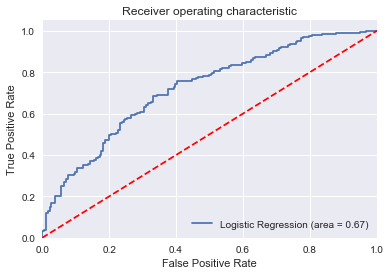

In [59]:
# ROC Curve
# The ROC curve measures the tradeoff between selecting as many True Positives as possible while avoiding False Positives.
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

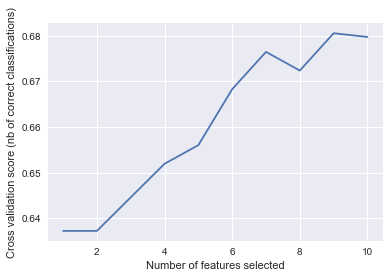

In [60]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()